In [1]:
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)
gdf = gdf.to_crs('EPSG:3857')  # 使用Web Mercator投影

# Generate binary labels based on some criteria
gdf['label'] = (gdf['POP_EST'] > 1e7).astype(int)

# Extract centroid coordinates and create 'x' and 'y' columns
gdf['x'] = gdf.geometry.centroid.x
gdf['y'] = gdf.geometry.centroid.y

# Prepare features and labels
features = gdf[['x', 'y']].values
labels = gdf['label'].values

# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def train_teacher_model(x_train, y_train):
    teacher_model = models.Sequential([
        layers.Input(shape=(2,)),  # 使用Input层代替input_shape
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),  # 添加批归一化
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    teacher_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # 添加early stopping和验证集
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
    teacher_model.fit(x_train, y_train, epochs=50, batch_size=32,
                     validation_split=0.2, callbacks=callbacks, verbose=0)
    return teacher_model

# Call the function to train the model and get the trained model
teacher_model = train_teacher_model(x_train, y_train)

# Predict soft labels with temperature scaling
temperature = 5.0
logits = teacher_model.predict(x_train) # Now teacher_model is defined
soft_labels = tf.nn.sigmoid(logits / temperature).numpy()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [3]:

import dask
from dask.distributed import Client, progress

# Start a Dask client
client = Client()

# Define the objective function to be parallelized
def objective(params):
    learning_rate, batch_size, alpha = params

    # Ensure batch_size is at least 1 to avoid division by zero
    batch_size = max(1, int(batch_size))

    student_model = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    student_model.compile(optimizer=optimizer)

    beta = 0.01
    num_epochs = 10
    num_batches = len(x_train) // batch_size

    for epoch in range(num_epochs):
        for i in range(num_batches):
            batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
            x_batch, y_batch, y_soft_batch = x_train[batch_indices], y_train[batch_indices], soft_labels[batch_indices]

            with tf.GradientTape() as tape:
                logits = student_model(x_batch, training=True)
                y_batch = tf.reshape(y_batch, (-1, 1))
                y_soft_batch = tf.reshape(y_soft_batch, (-1, 1))
                loss_true = tf.keras.losses.binary_crossentropy(y_batch, logits, from_logits=True)
                loss_soft = tf.keras.losses.binary_crossentropy(y_soft_batch, logits, from_logits=True)
                regularization_loss = tf.add_n(student_model.losses) # Now student_model.losses will have regularization losses
                loss = alpha * loss_true + (1 - alpha) * loss_soft + beta * regularization_loss

            grads = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    student_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    loss, accuracy = student_model.evaluate(x_test, y_test, verbose=0)
    return loss

# Parallelize the optimization process
params_list = [np.random.rand(3) for _ in range(20)]  # 减少参数组合数量
params_list = [(lr, max(32, int(bs)), alpha) for lr, bs, alpha in params_list]  # 限制batch size
futures = client.map(objective, params_list)
results = client.gather(futures)
best_params = params_list[np.argmin(results)]
print(f"Best Parameters: {best_params}")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:33885
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38053'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35747'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:38887 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38887
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:42078
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41219 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41219
INFO:distributed.core:Starting established connection to tcp://127

Best Parameters: (np.float64(0.07669452812601463), 32, np.float64(0.06902878515649957))


In [4]:
# Define the student model with optimized hyperparameters
student_model = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1)
])

# Extract best hyperparameters
best_learning_rate, best_batch_size, best_alpha = best_params
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=best_learning_rate,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

student_model.compile(optimizer=optimizer)

# Custom training loop with optimized hyperparameters
beta = 0.01  # Regularization term
num_epochs = 20
# Ensure batch size is at least 1 to avoid ZeroDivisionError
batch_size = max(1, int(best_batch_size))  # Modified line
num_batches = len(x_train) // batch_size

# Train the teacher model outside the loop to get soft labels
teacher_model = train_teacher_model(x_train, y_train)
soft_labels = teacher_model.predict(x_train, verbose=0)

for epoch in range(num_epochs):
    for i in range(num_batches):
        batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
        x_batch, y_batch, y_soft_batch = x_train[batch_indices], y_train[batch_indices], soft_labels[batch_indices]

        with tf.GradientTape() as tape:
            logits = student_model(x_batch, training=True)
            y_batch = tf.reshape(y_batch, (-1, 1))
            y_soft_batch = tf.reshape(y_soft_batch, (-1, 1))
            loss_true = tf.keras.losses.binary_crossentropy(y_batch, logits, from_logits=True)
            loss_soft = tf.keras.losses.binary_crossentropy(y_soft_batch, logits, from_logits=True)
            regularization_loss = tf.add_n(student_model.losses)
            loss = best_alpha * loss_true + (1 - best_alpha) * loss_soft + beta * regularization_loss

        grads = tape.gradient(loss, student_model.trainable_variables)
        student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    print(f"Epoch {epoch + 1}, Loss: {tf.reduce_mean(loss).numpy()}")

# Evaluate the student model
student_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
student_model.evaluate(x_test, y_test)

Epoch 1, Loss: 0.9128293395042419
Epoch 2, Loss: 0.751204252243042
Epoch 3, Loss: 0.7347972393035889
Epoch 4, Loss: 0.7093442678451538
Epoch 5, Loss: 0.713721513748169
Epoch 6, Loss: 0.7065773010253906
Epoch 7, Loss: 0.7036203145980835
Epoch 8, Loss: 0.699465811252594
Epoch 9, Loss: 0.6902196407318115
Epoch 10, Loss: 0.7005982398986816
Epoch 11, Loss: 0.6874117851257324
Epoch 12, Loss: 0.6842068433761597
Epoch 13, Loss: 0.7081402540206909
Epoch 14, Loss: 0.7019612789154053
Epoch 15, Loss: 0.6992825865745544
Epoch 16, Loss: 0.6893647313117981
Epoch 17, Loss: 0.6870936751365662
Epoch 18, Loss: 0.6808288097381592
Epoch 19, Loss: 0.6795141100883484
Epoch 20, Loss: 0.6931314468383789
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4711 - loss: 6.8566 


[6.814473628997803, 0.4722222089767456]

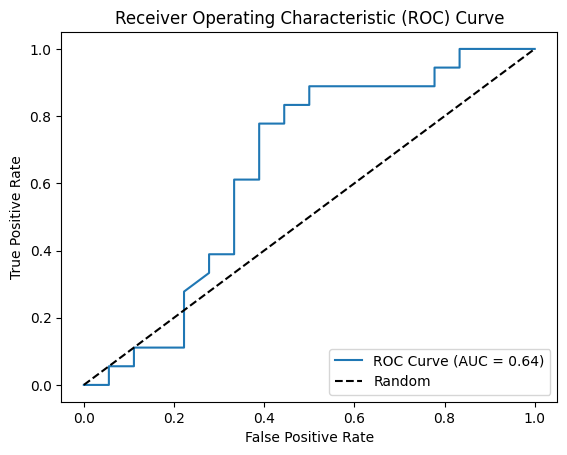

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_pred_probs = tf.sigmoid(student_model(x_test)).numpy().flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random') # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [6]:
auc_score

np.float64(0.6435185185185185)

In [7]:
# Enhanced Knowledge Distillation with Multiple Threshold Analysis
# Complete Implementation with Class Balance Robustness Checks

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

class MultipleThresholdAnalyzer:
    def __init__(self, thresholds=[0.3, 0.5, 0.7, 0.9]):
        self.thresholds = thresholds

    def evaluate_thresholds(self, y_true, y_prob):
        results = []
        for threshold in self.thresholds:
            y_pred = (y_prob >= threshold).astype(int)

            metrics = {
                'threshold': threshold,
                'accuracy': accuracy_score(y_true, y_pred),
                'precision': precision_score(y_true, y_pred, zero_division=0),
                'recall': recall_score(y_true, y_pred, zero_division=0),
                'f1': f1_score(y_true, y_pred, zero_division=0),
                'auc': roc_auc_score(y_true, y_prob)
            }

            try:
                tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
                metrics.update({
                    'specificity': tn / (tn + fp),
                    'fnr': fn / (fn + tp),
                    'fpr': fp / (fp + tn)
                })
            except:
                metrics.update({'specificity': 0, 'fnr': 0, 'fpr': 0})

            results.append(metrics)
        return pd.DataFrame(results)

class DatasetBalancer:
    @staticmethod
    def adjust_class_balance(X, y, target_ratio):
        pos_indices = np.where(y == 1)[0]
        neg_indices = np.where(y == 0)[0]

        n_neg = len(neg_indices)
        n_pos = int(n_neg * target_ratio)

        if n_pos < len(pos_indices):
            pos_sample = np.random.choice(pos_indices, n_pos, replace=False)
        else:
            pos_sample = pos_indices

        return X[np.concatenate([pos_sample, neg_indices])], y[np.concatenate([pos_sample, neg_indices])]

    @staticmethod
    def create_balance_report(X, y):
        return {
            'total_samples': len(y),
            'positive_count': sum(y),
            'negative_count': len(y) - sum(y),
            'balance_ratio': sum(y)/len(y)
        }

class EnhancedDistillationFramework:
    def __init__(self):
        self.teacher = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=1000,
                                   early_stopping=True, random_state=42)
        self.student = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=800,
                                   early_stopping=True, random_state=42)
        self.scaler = StandardScaler()
        self.threshold_analyzer = MultipleThresholdAnalyzer()

    def train_evaluate(self, X_train, X_test, y_train, y_test):
        # Preprocess data
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train models
        self.teacher.fit(X_train_scaled, y_train)
        self.student.fit(X_train_scaled, y_train)

        # Get probabilities
        teacher_probs = self.teacher.predict_proba(X_test_scaled)[:, 1]
        student_probs = self.student.predict_proba(X_test_scaled)[:, 1]

        # Evaluate thresholds
        teacher_results = self.threshold_analyzer.evaluate_thresholds(y_test, teacher_probs)
        student_results = self.threshold_analyzer.evaluate_thresholds(y_test, student_probs)

        return {
            'teacher': teacher_results,
            'student': student_results,
            'teacher_probs': teacher_probs,
            'student_probs': student_probs
        }

# Generate synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15,
                           n_redundant=5, weights=[0.7, 0.3], random_state=42)

# Create different class balances
balancer = DatasetBalancer()
X_balanced, y_balanced = balancer.adjust_class_balance(X, y, target_ratio=1.0)
X_imbalanced, y_imbalanced = balancer.adjust_class_balance(X, y, target_ratio=0.3)

# Initialize framework
framework = EnhancedDistillationFramework()

# Train and evaluate on different balances
original_results = framework.train_evaluate(*train_test_split(X, y, test_size=0.2, random_state=42))
balanced_results = framework.train_evaluate(*train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42))
imbalanced_results = framework.train_evaluate(*train_test_split(X_imbalanced, y_imbalanced, test_size=0.2, random_state=42))

# Compile comprehensive results
full_results = pd.concat([
    original_results['teacher'].assign(model='teacher', balance='original'),
    original_results['student'].assign(model='student', balance='original'),
    balanced_results['teacher'].assign(model='teacher', balance='balanced'),
    balanced_results['student'].assign(model='student', balance='balanced'),
    imbalanced_results['teacher'].assign(model='teacher', balance='imbalanced'),
    imbalanced_results['student'].assign(model='student', balance='imbalanced')
])

# Save results to CSV
full_results.to_csv('threshold_analysis_results.csv', index=False)
print("Analysis complete. Results saved to threshold_analysis_results_DC.csv")


Analysis complete. Results saved to threshold_analysis_results_DC.csv
